In [2]:
# import sys
# sys.path.insert(0,'/home/kmatsuno/h5py/build/lib.linux-x86_64-2.7/')
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *
from scripts.decorr_lscale_y import get_L99


# Get transverse decorr lengthscale
def get_lscale(y,Lvv,thresh=0.20):
    Ny = np.size(Lvv)
    imax0 = np.argmax(Lvv)
    # find inflection point
    dLdx = (Lvv[:-1:]-Lvv[1::])/abs(y[0]-y[1])
    asign = np.sign(dLdx)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    imax1,imax2=None,None
    
    for i in range(1,Ny/4):
        if signchange[imax0-i]==1:
            imax1 = imax0-i
            break
    for i in range(1,Ny/4):
        if signchange[imax0+i]==1:
            imax2 = imax0+i
            break
    if (imax1 is None): 
        print('Error finding inflection points 1')
        imax1 = 0
    if (imax2 is None): 
        print('Error finding inflection points 2')
        imax2 = Ny-1
    i1 = np.argmin(abs(Lvv[imax1:imax0]-thresh)) + imax1
    i2 = np.argmin(abs(Lvv[imax0:imax2]-thresh)) + imax0 
    L = abs(y[i1]-y[i2])    
    return L,i1,i2


def visualize_one(reader, step, qname, plane, cmap, dtheta=0,domega=0,savename=''):
    reader.step = step
    fs = 12
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    
    fig = plt.figure(figsize=(4,6), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    if plane=='xy': data2plot = np.fliplr(np.transpose(q))
    if plane=='xz': data2plot = np.transpose(q)
    im = axarr.imshow( data2plot, cmap=cmap, origin='lower', interpolation='nearest')#spline36
    axarr.set_xticks([])
    axarr.set_yticks([]) 
    #axarr.set_ylim([Ny/2-200,Ny/2+200])
    axarr.set_title(r'Time: t = ' + str(np.around(reader.time,-1)),size=fs)
    
    axarr.set_xlabel('x')
    if plane=='xy':axarr.set_ylabel('y')
    if plane=='xz':axarr.set_ylabel('z')
    
    # set the colorbar
    divider1 = make_axes_locatable(axarr)
    cax = divider1.append_axes('right', size='5%', pad=0.1)
    maxval = np.amax(q);
    minval = np.amin(q);
    cbar = plt.colorbar(im, cax,ticks=[minval, maxval])
    cbar.ax.set_yticklabels(['%0.2f'%(minval), '%0.2f'%(maxval)]) 
    cbar.ax.tick_params(labelsize=0.75*fs)    
    
    # overlay the centerline, momentum and vorticity thickness
    if plane=='xy' and (dtheta>0 or domega>0):
        xplot = np.linspace(0,Nx-1,10)
        ones = np.ones(np.shape(xplot))
        centerline = Ny/2*ones
        lw = 0.5
        axarr.plot(xplot,centerline,'k-',alpha=0.5,linewidth=lw)
        if (domega>0):
            axarr.plot(xplot,centerline+dy*domega,'k-.',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*domega,'k-.',alpha=0.5,linewidth=lw)
        if (dtheta>0):
            axarr.plot(xplot,centerline+dy*dtheta,'k--',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*dtheta,'k--',alpha=0.5,linewidth=lw)
        # Get utilde, normalize by L99:
        fname = filename_prefix+'utilde_%04d.dat'%tID
        utilde = np.fromfile(fname,count=-1,sep=' ')
        L99,itop,ibot = get_L99(yplot,utilde)
    
    # set the overall title and save
    if savename:
        plt.savefig(savename, dpi=500)#, bbox_inches='tight',pan_inches=0.5)
        plt.close(fig)
        print "Saved plot to ",savename
    else: plt.show
    

In [30]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
directory = '/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/mira/Mc20/rr1/1024x1448x512/'


filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
yplot = np.linspace(-Ly/2,Ly/2,int(Ny))
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

tmp = directory.split('mira')[-1]
dir_out = '/home/kmatsuno/ShearLayerData/production'+tmp
print(dir_out)

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/


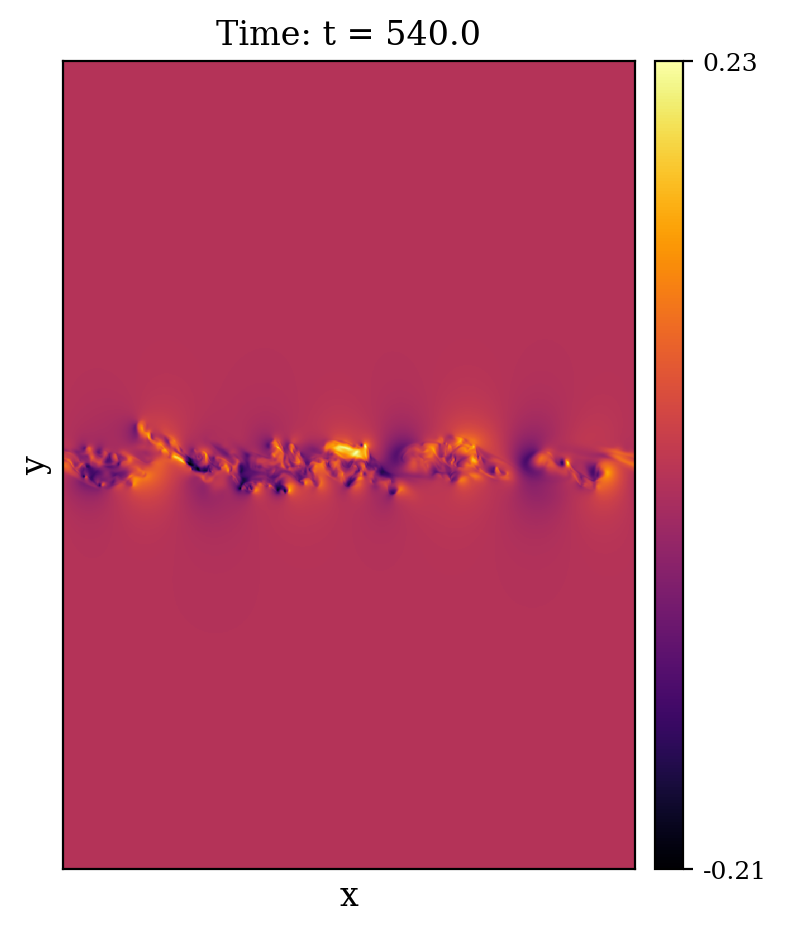

In [11]:
## plot a streamwise xy slice

zslice = Nz/2
reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
step = max(steps)
visualize_one(reader, step, qname='rhov', plane='xy',cmap='inferno',dtheta=0,domega=0,savename="") 

#'inferno','afmhot','viridis'

724


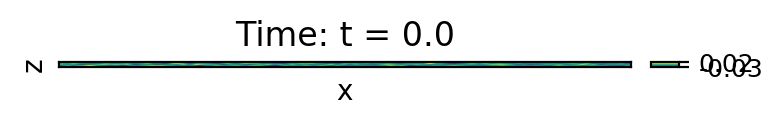

In [23]:
# plot an spanwise xz slice
yslice = Ny/2
print(yslice)
reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
step = max(steps)
visualize_one(reader, step, qname='v',plane='xz',cmap='viridis',savename="") # 02:viridis,08:inferno,20:magma

0.2
L99=43.6765722184
Error finding inflection points 1
Error finding inflection points 2
/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512//autocorr_vv_0111.h5


KeyError: "Unable to open object (object 'qx' doesn't exist)"

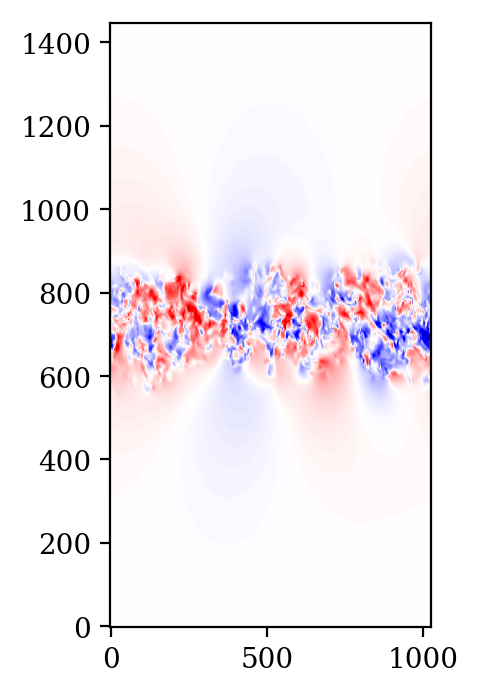

In [23]:
def visualize_normL99_xy(reader, step, qname, cmap, inp=None, savename=''):
    reader.step = step
    fs = 10
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    if qname is 'v': q /= inp.du # for velocity only!
    
    # Get utilde, normalize by L99:
    try: 
        fname = filename_prefix+'utilde_%04d.dat'%step
        utilde = np.fromfile(fname,count=-1,sep=' ')
    except: 
        fname = dir_out+'shearlayer_utilde_%04d.dat'%step
        utilde = np.fromfile(fname,count=-1,sep=' ')
    L99,itop,ibot = get_L99(yplot,utilde)
    print('L99={}'.format(L99))

    # Corresponding nx,ny for one L99?
    nx = Nx*L99/Lx
    ny = Ny*L99/Ly
    
    fig = plt.figure(figsize=(4,4), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    data2plot = np.fliplr(np.transpose(q))
    im = axarr.imshow( data2plot, cmap=cmap, origin='lower', 
                      interpolation='nearest',aspect=Ly/Lx,vmin=-qmax,vmax=qmax)#spline36
    
    # Plot the Ly lengthscales:
    fname = dir_out+'/lscale_%s%s_%04d.dat'%(qname,qname,step)
    autocorr = np.fromfile(fname,sep=' ')
    autocorr = np.reshape(autocorr,[Ny,3])
    autocorr = autocorr[:,0]
    ly,i1,i2 = get_lscale(y,autocorr,thresh=0.25)
    ny_decorr = ny*ly/L99
    
    # Plot the Lx lengthscales:
    x = np.linspace(0,Lx,Nx)
    if inp.rr==1:
        fname = dir_out+'/autocorr_%s%s_%04d.h5'%(qname,qname,step)
        print(fname)
        hf =  h5py.File(fname,'r')
        autocorr2D = np.abs(np.fft.fftshift(hf['qx']))
        for k in range(Nz): autocorr2D /= np.amax(autocorr2D[:,k])
        autocorr = np.mean(autocorr2D,axis=-1)
        #plt.figure();plt.plot(autocorr)
        lx,i1,i2 = get_lscale(x,autocorr,thresh=0.2)
    # Corresponding nx,ny for lx,ly?
    nx_decorr = nx*lx/L99
    hw = 6
    hl = 6
    lw = 1.3
    plt.arrow(nx,Ny/2,0,ny_decorr/2, ec='k',fc='k',lw = lw, head_width=hw, head_length=hl)
    plt.arrow(nx,Ny/2,0,-ny_decorr/2,ec='k',fc='k',lw = lw, head_width=hw, head_length=hl)
    plt.arrow(nx,Ny/2,nx_decorr/2,0, ec='k',fc='k',lw = lw, head_width=hw, head_length=hl)
    plt.arrow(nx,Ny/2,-nx_decorr/2,0,ec='k',fc='k',lw = lw, head_width=hw, head_length=hl)
#     plt.plot([0,Nx],[Ny/2,Ny/2],'k-.')
#     plt.plot([0,Nx],[Ny/2+ny/4,Ny/2+ny/4],'k:')
#     plt.plot([0,Nx],[Ny/2-ny/4,Ny/2-ny/4],'k:')
    
    # Set axis
    plt.xticks([0,nx/2.,nx,nx*1.5,nx*2],['0','0.5','1.0','1.5','2.0'])
    plt.yticks([Ny/2-ny/2,0,Ny/2+ny/2],['-0.5','0','0.5'])
    axarr.set_ylim([Ny/2-ny,Ny/2+ny])    
    axarr.set_xlim([0,nx*2])    
    axarr.set_xlabel(r'$x/L_{99}$')
    axarr.set_ylabel(r'$y/L_{99}$')
    
    # set the colorbar
#     divider1 = make_axes_locatable(axarr)
#     cax = divider1.append_axes('top', size='3%', pad=0.25)
#     cbar = plt.colorbar(im, cax,orientation='horizontal',ticks=[-qmax, qmax])
#     cbar.ax.set_yticklabels(['%0.2f'%(-qmax), '%0.2f'%(qmax)]) 
#     cbar.ax.tick_params(labelsize=0.75*fs)    

print(inp.Mc)
qmax=0.5
zslice = Nz/2
reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
step = max(steps)-2
visualize_normL99_xy(reader, step, 'v', 'seismic', inp=inp, savename='')

2.0
L99=33.8908085695


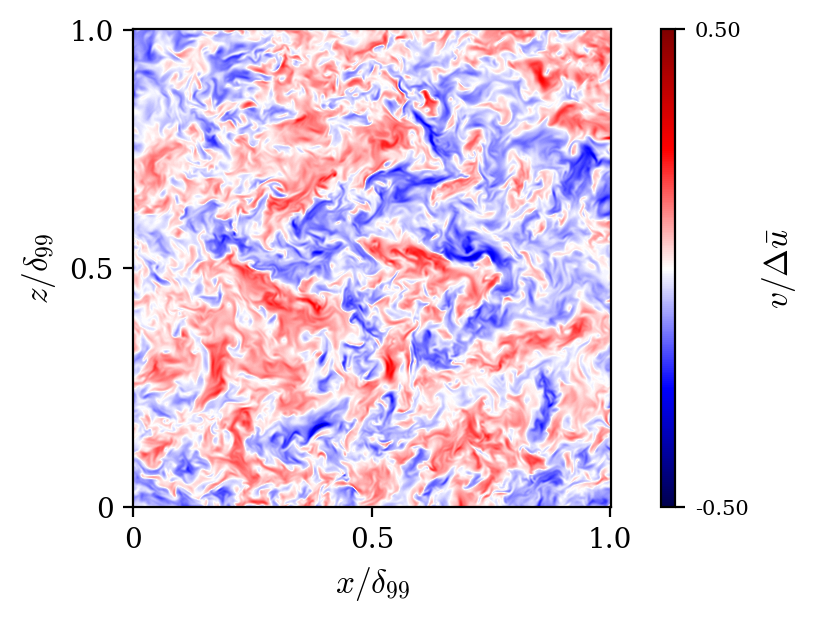

In [37]:
def visualize_normL99_xz(reader, step, qname, cmap, inp=None, savename=''):
    reader.step = step
    fs = 10
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    if qname is 'v': q /= inp.du # for velocity only!

    # Get utilde, normalize by L99:
    try: 
        fname = filename_prefix+'utilde_%04d.dat'%step
        utilde = np.fromfile(fname,count=-1,sep=' ')
    except: 
        fname = dir_out+'shearlayer_utilde_%04d.dat'%step
        utilde = np.fromfile(fname,count=-1,sep=' ')
    L99,itop,ibot = get_L99(yplot,utilde)
    print('L99={}'.format(L99))
    
    # Corresponding nx,nz for one L99?
    nx = Nx*L99/Lx
    nz = Nz*L99/Lz
    
    fig = plt.figure(figsize=(3.5,3.5), dpi=200) 
    axarr = plt.axes()

    # Plot the colors
    data2plot = np.fliplr(np.transpose(q))
    im = axarr.imshow( data2plot, cmap=cmap, vmin=-qmax,vmax=qmax,origin='lower', interpolation='spline36',aspect='equal')#spline36
    plt.xticks([0,nx/2.,nx-1],['0','0.5','1.0'])
    plt.yticks([0,nz/2,nz-1],['0','0.5','1.0'])#'%0.2f'%(-Ly/L99*ibot/Ny),'0','%0.2f'%(Ly/L99*ibot/Ny)])
    axarr.set_xlim([0,nx])    
    axarr.set_ylim([0,nz])    
    axarr.set_xlabel(r'$x/\delta_{99}$')
    axarr.set_ylabel(r'$z/\delta_{99}$')
    
    # Plot the Lx,Ly lengthscales:
    """
    x = np.linspace(0,Lx,Nx)
    z = np.linspace(0,Lz,Nz)
    if inp.rr==1:
        fname = dir_out+'/autocorr_%s%s_%04d.h5'%(qname,qname,step)
        print(fname)
        hf =  h5py.File(fname,'r')
        try:autocorr = np.mean(hf['qx'],axis=-1)
        except:autocorr = np.mean(hf['corrx'],axis=-1)
        autocorr = np.fft.fftshift(autocorr)
        lx,i1,i2 = get_lscale(x,autocorr,thresh=0.2)        
        try: autocorr = np.mean(hf['qz'],axis=0)
        except:autocorr = np.mean(hf['corrz'],axis=0)
        autocorr = np.fft.fftshift(autocorr)
        #plt.figure();plt.plot(autocorr)
        lz,i1,i2 = get_lscale(z,autocorr,thresh=0.2)
        print(lx/L99,lz/L99)
    # Corresponding nx,nz for lx,lz?
    nx_decorr = nx*lx/L99
    nz_decorr = nz*lz/L99
    hw = 6
    hl = 6
    lw = 3
    plt.arrow(nx/2,nz/2,nx_decorr/2,0,ec='k',fc='k',lw=lw,head_width=hw, head_length=hl)
    plt.arrow(nx/2,nz/2,-nx_decorr/2,0,ec='k',fc='k',lw=lw,head_width=hw, head_length=hl)
    plt.arrow(nx/2,nz/2,0,nz_decorr/2,ec='k',fc='k',lw=lw,head_width=hw, head_length=hl)    
    plt.arrow(nx/2,nz/2,0,-nz_decorr/2,ec='k',fc='k',lw=lw,head_width=hw, head_length=hl)
    """
    
    #set the colorbar
    divider1 = make_axes_locatable(axarr)
    maxval = 0.5
    minval = -0.5
    #cax = divider1.append_axes('top', size='3%', pad=0.25)
    #cbar = plt.colorbar(im, cax,orientation='horizontal',ticks=[minval, maxval])
    cax = divider1.append_axes('right', size='3%', pad=0.25)
    cbar = plt.colorbar(im, cax,orientation='vertical',ticks=[minval, maxval])
    cbar.ax.set_yticklabels(['%0.2f'%(minval), '%0.2f'%(maxval)]) 
    if qname=='v': cbar.set_label(r'$v/\Delta\bar{u}$')
    else: cbar.set_label(qname)
    cbar.ax.tick_params(labelsize=0.75*fs)    

qmax = 0.5
print(inp.Mc)
yslice = Ny/2
reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice,reader.domain_size[2]-1,)
step = max(steps)-2
visualize_normL99_xz(reader, step, 'v', 'seismic', inp=inp, savename='')

In [15]:
# plot all, don't forget to check reader.subdomain
qname = 'rhov'
plane = 'xy'

if plane=='xy':
    zslice = Nz/2
    reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
elif plane=='xz':
    yslice = Ny/2
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)

directory = '/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/'
for step in steps[:]:
    savename = directory+"/img/slice_%s_%s_%04d.png"%(plane,qname,step)
    visualize_one(reader, step, qname=qname, plane=plane,cmap='inferno',dtheta=0,domega=0,savename=savename) 
print('Done')

Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0000.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0001.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0002.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0003.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0004.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0005.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512//img/slice_xy_rhov_0006.png
Saved plot to  /lus/theta-fs0/projects/HighMachTurbulence/ShearLayerD